## ABOUT

- validation set is continguous with training set (vs random sample)
- add other image transforms using gramian angular field
- even bigger custom head
- add training callbacks
---
- Best MAE: 2.16  
- LB Score: 1.768
- submission allegedly had MAE of 2.09

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.48
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v6'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = 224  # (y, x)
bs = 32
num_workers = 6     # set to available cores

transform = 'spectogram'  # which time series to visual transformation to use

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following has been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
path.ls()

[PosixPath('/root/.fastai/data/kaggle_earthquake/sample_submission.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test.zip'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train.csv.zip'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/X_train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/y_train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/submission_v6.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test_images'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/v6-submission.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test')]

In [7]:
# look at images dir
img_path = path/f'train_images/{transform}'
img_path.ls()[:5]

[PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_0.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_1.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_2.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_3.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_4.png')]

In [8]:
# look at saved models dir
save_path = path/'saved_models'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
save_path.ls()[:5]

[PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v5-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v5-stage-1-2.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-1-2.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-2-1.pth')]

In [9]:
# load segment CSVs
pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [10]:
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164258,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791033,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [11]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


## MODEL

In [12]:
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf

In [13]:
gen_label(img_path/'seg_0.png')

1.4307971859

In [14]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [15]:
fake_label = 0.
valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_idx(valid_idx=valid_idx)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [16]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [17]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3000
valid:  1194
test:   2624

TOTAL:  6818


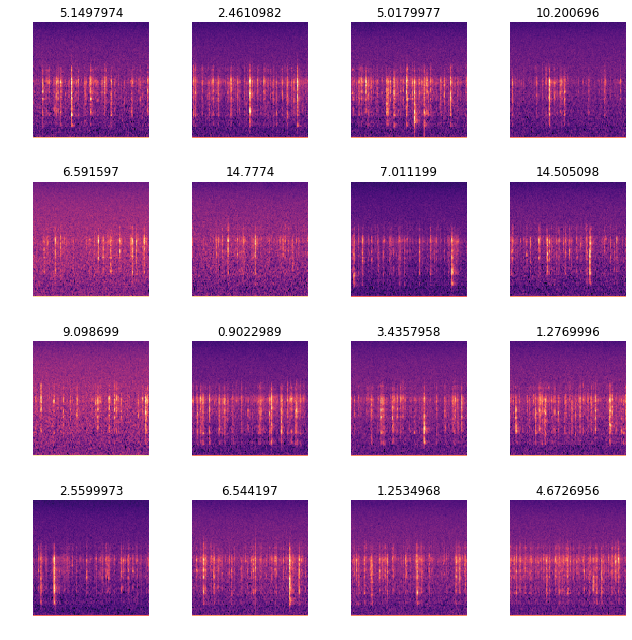

In [18]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [20]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [21]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7
    elif arch == models.resnet50 and size == 224: return 2048*7*7

In [67]:
# define custom heads
small_head_reg1 = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

medium_head_reg1 = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

big_head_reg1 = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1))

In [68]:
# define callback parameters
lr_min_delta = 0.0001
lr_patience = 2
lr_factor = 0.2

stop_min_delta = 0.0001
stop_patience = 10

In [69]:
# create learner with callbacks
learn = cnn_learner(data, arch,
                    custom_head=big_head_reg1,
                    loss_func=l1_loss,
                    metrics=[mean_squared_error, mean_absolute_error],
                    callback_fns=[
                        partial(ReduceLROnPlateauCallback,
                                monitor='mean_absolute_error',
                                mode='min',
                                min_delta=lr_min_delta,
                                patience=lr_patience,
                                factor=lr_factor),
                        partial(EarlyStoppingCallback,
                                monitor='mean_absolute_error',
                                mode='min',
                                min_delta=stop_min_delta,
                                patience=stop_patience)])

In [70]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________

## TRAIN

#### Helper functions

In [71]:
def plot_lr_find(learn):
    learn.lr_find()
    learn.recorder.plot()

In [72]:
def fit_one_cycle(learn, n_epochs, max_lr, stage):
    learn.fit_one_cycle(n_epochs, max_lr=max_lr, callbacks=[
        SaveModelCallback(learn,
                          monitor='mean_absolute_error',
                          mode='min',
                          every='improvement',
                          name=save_path/f'{version}-{stage}-best')])
    learn.recorder.plot_losses()
    learn.recorder.plot_lr(show_moms=True)

#### Stage 1.1

In [73]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


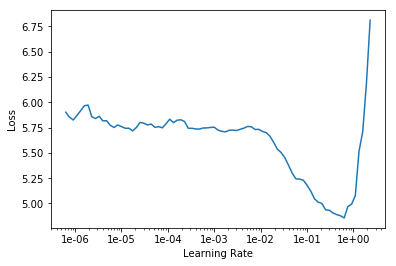

In [50]:
plot_lr_find(learn)

In [74]:
stage = 's1.1'
n_epochs = 4   # 4
max_lr = slice(2e-2)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,3.289215,2.324671,9.160893,2.324671,00:14
1,2.473065,2.410979,8.934522,2.410979,00:14
2,2.244068,2.168027,7.927658,2.168027,00:14
3,1.962315,2.227452,8.206309,2.227452,00:15


Better model found at epoch 0 with mean_absolute_error value: 2.3246705532073975.
Better model found at epoch 2 with mean_absolute_error value: 2.168027400970459.


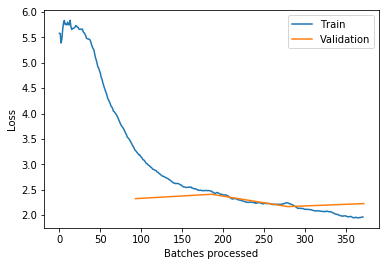

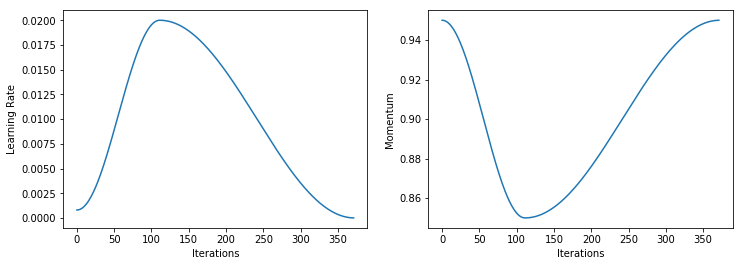

In [75]:
fit_one_cycle(learn, n_epochs, max_lr, stage)

#### Stage 1.2

In [76]:
learn.load(save_path/f'{version}-s1.1-best');

In [77]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


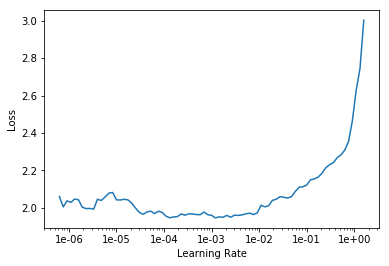

In [78]:
plot_lr_find(learn)

In [79]:
stage = 's1.2'
n_epochs = 4   # 4
max_lr = slice(3e-4)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.922338,2.210060,7.987482,2.210060,00:15
1,1.917910,2.193619,8.051486,2.193620,00:15
2,1.904440,2.178906,7.975253,2.178907,00:15
3,1.880614,2.202050,8.023923,2.202050,00:15


Better model found at epoch 0 with mean_absolute_error value: 2.2100603580474854.
Better model found at epoch 1 with mean_absolute_error value: 2.193619728088379.
Better model found at epoch 2 with mean_absolute_error value: 2.1789066791534424.


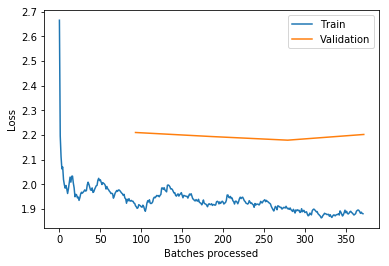

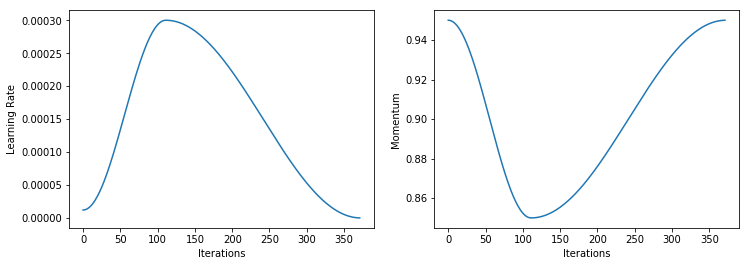

In [80]:
fit_one_cycle(learn, n_epochs, max_lr, stage)

#### Stage 2.1

In [81]:
learn.load(save_path/f'{version}-s1.2-best');

In [82]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


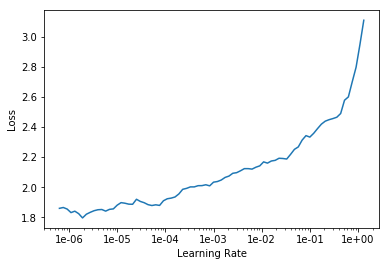

In [83]:
plot_lr_find(learn)

In [85]:
stage = 's2.1'
n_epochs = 4
max_lr = slice(1e-6, 1e-5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.911696,2.190430,8.053594,2.190430,00:19
1,1.859477,2.224848,8.199077,2.224848,00:19
2,1.764515,2.253932,8.270504,2.253933,00:19
3,1.717846,2.239682,8.265071,2.239682,00:19


Better model found at epoch 0 with mean_absolute_error value: 2.1904296875.
Epoch 3: reducing lr to 8.000000000000001e-12


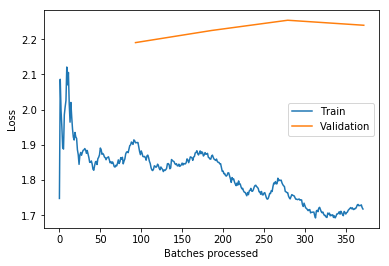

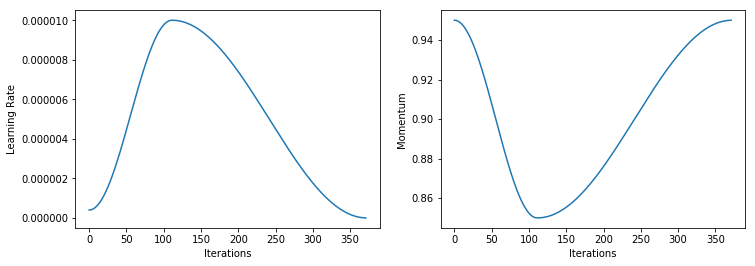

In [86]:
fit_one_cycle(learn, n_epochs, max_lr, stage)

## RESULTS

In [ ]:
learn.load(save_path/f'{version}-s1.2-best');

In [ ]:
# plot histograms of results
def plot_histograms(preds, targs):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    fig.suptitle("Histograms of segment's time to failure")

    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('preds TTF'); ax1.set_ylabel('No. of segments')
    ax2.hist(targs, bins=50); ax2.set_xlabel('targs TTF'); ax2.set_ylabel('No. of segments')

#### Training Set

In [ ]:
train_preds, train_targs = learn.get_preds(ds_type=DatasetType.Fix)

In [ ]:
plot_histograms(train_preds, train_targs)

#### Validation Set

In [ ]:
valid_preds, valid_targs = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
plot_histograms(valid_preds, valid_targs)

#### Test Set

In [ ]:
test_preds, test_targs = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
plot_histograms(test_preds, test_targs)

## SUBMISSION

In [ ]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [ ]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() for i in range(len(test_preds))]

In [ ]:
submission.head()

In [ ]:
submission_file = path/f'{version}-submission.csv'
submission.to_csv(submission_file)

In [ ]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f $submission_file -m "Message"